In [1]:
%cd ~/mechanistic-unlearning
import functools
import os
import gc
import json
from tkinter import font

from dataset.custom_dataset import PairedInstructionDataset
import torch

from transformer_lens import HookedTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import numpy as np
from tqdm.auto import tqdm
from datasets import load_dataset
import einops
from transformer_lens import ActivationCache

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/root/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


/root/mechanistic-unlearning


/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MODELS = ['google/gemma-7b', 'google/gemma-2-9b', 'meta-llama/Meta-Llama-3-8B']
model_name = MODELS[2]


In [4]:
model = HookedTransformer.from_pretrained(
    model_name,
    device='cuda',
    default_padding_side="left",
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)
torch.set_grad_enabled(False)
model.eval()
model.half()
tokenizer = model.tokenizer


Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


Loaded pretrained model meta-llama/Meta-Llama-3-8B into HookedTransformer


### Probing Functions

In [5]:
# Need to 
# 1. Probe for correct sport with no changes
# 2. Probe for correct sport with just <bos>name
# 3. Probe after meal ablating attention heads after layer 2
# 4. Probe after meal ablating attention heads after layer 2 and just <bos>name

import pandas as pd

df = pd.read_csv('experiments/sports_facts_manual/sports.csv')
df = df[:500]

def tokenize_instructions(tokenizer, instructions):
    # Use this to put the text into INST tokens or add a system prompt
    return tokenizer(
        instructions,
        padding=True,
        truncation=False,
        return_tensors="pt",
        # padding_side="left",
    ).input_ids

def probe_last_layer(model, prompt_toks, targets):
    with torch.set_grad_enabled(False), torch.cuda.amp.autocast(True, model.W_in.dtype):
        _, cache = model.run_with_cache(
            prompt_toks,
            names_filter = lambda name: name == f"blocks.{model.cfg.n_layers-1}.hook_resid_post"
        )
        cache = cache[f"blocks.{model.cfg.n_layers-1}.hook_resid_post"][:, -1, :]

    X = cache.cpu().float().numpy()
    print(X.shape, len(targets))
    target_classes = []
    for target in targets:
        if target == "basketball":
            target_classes.append(0)
        elif target == "baseball":
            target_classes.append(1) 
        elif target == "football":
            target_classes.append(2)
    y = np.array(target_classes)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train logistic regression
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

    test_acc = clf.score(X_test, y_test)
    print(f"Accuracy: {test_acc}")

    return test_acc

def probe_across_layers(model, prompt_toks, targets):

    with torch.set_grad_enabled(False), torch.cuda.amp.autocast(True, model.W_in.dtype):
        _, cache = model.run_with_cache(
            prompt_toks,
            names_filter = lambda name: 'resid_post' in name
        )
        cache = torch.stack([cache[key][:, -1, :] for key in cache.keys()], dim=0) # layer batch d_model

    results = []
    for layer in tqdm(range(model.cfg.n_layers)):
        X = cache[layer].reshape(-1, cache[layer].shape[-1]).cpu().float().numpy()
        target_classes = []
        for target in targets:
            if target == "basketball":
                target_classes.append(0)
            elif target == "baseball":
                target_classes.append(1) 
            elif target == "football":
                target_classes.append(2)
        y = np.array(target_classes)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # train logistic regression
        clf = LogisticRegression(random_state=0, max_iter=200, solver='sag', n_jobs=64).fit(X_train, y_train)

        test_acc = clf.score(X_test, y_test)
        print(f"Layer {layer} Accuracy: {test_acc}")
        results.append(test_acc)

    return results

def get_mean_cache(model, hook_name="attn_out"):
    pile = iter(load_dataset('monology/pile-uncopyrighted', split='train', streaming=True))
    text = [next(pile)['text'] for i in range(25)]
    # tokenize text, truncating to the first 50 tokens
    toks = tokenizer(
        text,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=50,
    ).input_ids
    print(toks.shape)
    with torch.set_grad_enabled(False), torch.cuda.amp.autocast(True, model.W_in.dtype):
        _, mean_cache = model.run_with_cache(
            toks,
            names_filter = lambda name: any([h_name in name for h_name in [hook_name]])
        )
    return mean_cache

def mean_ablate_hook(act, hook, mean_cache):
    if hook.layer() >= 5:
        print(f'Hooked {hook.name}')
        act = mean_cache[hook.name]
    return act


### Probing to find the FLU layers

In [6]:
#%% Getting Cache
print('Getting mean cache')
m_cache = get_mean_cache(model)
print('Got mean cache')

mean_cache = {}
for k in m_cache.keys():
    mean_cache[k] = einops.reduce(
        m_cache[k],
        'batch seq d_model -> 1 1 d_model',
        'mean'
    )

print('start probing')
#%% Probing
results = {}
full_prompt_toks = tokenize_instructions(tokenizer, df['prompt'].tolist()) # Full prompt
athl_prompt_toks = tokenize_instructions(tokenizer, df['athlete'].tolist()) # <bos>name

print('tokenized')
model.reset_hooks()
results['Prompt'] = probe_across_layers(model, full_prompt_toks, df['sport'].tolist())

# Add mean ablate hooks
model.add_hook(
    lambda name: 'attn_out' in name,
    functools.partial(mean_ablate_hook, mean_cache=mean_cache),
    "fwd"
)
results['+ Ablate Heads at Layers >= 5'] = probe_across_layers(model, full_prompt_toks, df['sport'].tolist())

model.reset_hooks()
results['Athlete'] = probe_across_layers(model, athl_prompt_toks, df['sport'].tolist())

# Add mean ablate hooks
model.add_hook(
    lambda name: 'attn_out' in name,
    functools.partial(mean_ablate_hook, mean_cache=mean_cache),
    "fwd"
)
results['+Ablate Heads at Layers >= 5'] = probe_across_layers(model, athl_prompt_toks, df['sport'].tolist())
model.reset_hooks()


Getting mean cache
torch.Size([25, 50])
Got mean cache
start probing
tokenized


  3%|▎         | 1/32 [00:01<00:43,  1.40s/it]

Layer 0 Accuracy: 0.36


  6%|▋         | 2/32 [00:02<00:35,  1.18s/it]

Layer 1 Accuracy: 0.36


  9%|▉         | 3/32 [00:03<00:34,  1.18s/it]

Layer 2 Accuracy: 0.41


 12%|█▎        | 4/32 [00:05<00:40,  1.46s/it]

Layer 3 Accuracy: 0.75


 16%|█▌        | 5/32 [00:09<01:01,  2.28s/it]

Layer 4 Accuracy: 0.96


 19%|█▉        | 6/32 [00:14<01:28,  3.40s/it]

Layer 5 Accuracy: 0.98


/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 7/32 [00:22<01:58,  4.74s/it]

Layer 6 Accuracy: 0.98


 25%|██▌       | 8/32 [00:29<02:12,  5.52s/it]

Layer 7 Accuracy: 0.97


/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 9/32 [00:36<02:21,  6.14s/it]

Layer 8 Accuracy: 0.97


/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 10/32 [00:44<02:24,  6.56s/it]

Layer 9 Accuracy: 0.98


 34%|███▍      | 11/32 [00:47<01:56,  5.53s/it]

Layer 10 Accuracy: 0.95


 38%|███▊      | 12/32 [00:49<01:30,  4.54s/it]

Layer 11 Accuracy: 0.94


 41%|████      | 13/32 [00:51<01:11,  3.74s/it]

Layer 12 Accuracy: 0.96


 44%|████▍     | 14/32 [00:53<00:58,  3.24s/it]

Layer 13 Accuracy: 0.99


 47%|████▋     | 15/32 [00:56<00:53,  3.13s/it]

Layer 14 Accuracy: 1.0


 50%|█████     | 16/32 [01:00<00:54,  3.41s/it]

Layer 15 Accuracy: 1.0


 53%|█████▎    | 17/32 [01:05<00:57,  3.85s/it]

Layer 16 Accuracy: 1.0


 56%|█████▋    | 18/32 [01:11<01:02,  4.49s/it]

Layer 17 Accuracy: 1.0


 59%|█████▉    | 19/32 [01:18<01:05,  5.08s/it]

Layer 18 Accuracy: 1.0


/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▎   | 20/32 [01:25<01:09,  5.80s/it]

Layer 19 Accuracy: 1.0


/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 21/32 [01:33<01:09,  6.31s/it]

Layer 20 Accuracy: 1.0


/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 22/32 [01:40<01:06,  6.67s/it]

Layer 21 Accuracy: 1.0


/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 23/32 [01:48<01:02,  6.92s/it]

Layer 22 Accuracy: 1.0


 72%|███████▏  | 23/32 [01:53<00:44,  4.93s/it]


KeyboardInterrupt: 

/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


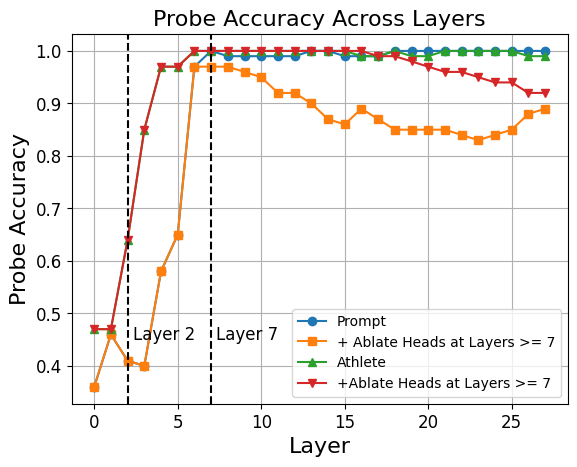

In [ ]:
#%% Plot results
import matplotlib.pyplot as plt
fig = plt.figure()
markers = ['o', 's', '^', 'v', '*', 'p', 'P', 'X', 'd']
for i, (k, v) in enumerate(results.items()):
    plt.plot(v, label=k, marker=markers[i])

# Add vertical dotted lines at x = 2, x = 7
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=7, color='k', linestyle='--')
# Label these vertical lines
plt.text(2.3, 0.45, 'Layer 2', fontsize=12)
plt.text(7.3, 0.45, 'Layer 7', fontsize=12)

plt.legend()
plt.xlabel('Layer', fontsize=16)
plt.ylabel('Probe Accuracy', fontsize=16)
plt.title('Probe Accuracy Across Layers', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()
fig.savefig(f"experiments/sports_facts_manual/results/{model_name.replace('/', '_')}_probe_across_layers.pdf")


#### Finding FLU heads through patching and measuring probe accuracy

In [16]:
full_prompt_toks = tokenize_instructions(tokenizer, df['prompt'].tolist()) # Full prompt
athl_prompt_toks = tokenize_instructions(tokenizer, df['athlete'].tolist()) # <bos>name
m_cache = get_mean_cache(model, hook_name="hook_z")
mean_cache = {}
for k in m_cache.keys():
    mean_cache[k] = einops.reduce(
        m_cache[k],
        'batch seq head d_model -> 1 1 head d_model',
        'mean'
    )

#%%
def act_patch_hook_z(act, hook, patch_cache, patch_layer, patch_head):
    # heads_to_patch is [(layer, head)]
    # heads = [head for layer, head in heads_to_patch if layer == hook.layer()]

    # act is batch head seq d_model

    # want to patch head and every head after layer 7
    if hook.layer() == patch_layer:
        act[:, :, patch_head, :] = patch_cache[hook.name][:, :, patch_head, :]
    elif hook.layer() >= 7:
        act = patch_cache[hook.name]

    return act


layer_range = range(0, 7)
head_range = range(0, model.cfg.n_heads)

heads_to_patch = [
    (layer, head)
    for layer in layer_range
    for head in head_range
]

# Get patch cache
results_mat = torch.zeros((len(list(layer_range)), len(list(head_range))), device=device)
for (layer, head) in tqdm(heads_to_patch):
    # print(f'Patching L{layer}H{head}')

    model.reset_hooks()

    model.add_hook(
        lambda name: 'hook_z' in name,
        functools.partial(act_patch_hook_z, patch_cache=mean_cache, patch_layer=layer, patch_head=head),
        "fwd"
    )

    results_mat[layer, head] += probe_last_layer(model, full_prompt_toks, df['sport'].tolist()) 

    model.reset_hooks()
    
#%%
# Get baseline accuracy
model.reset_hooks()
model.add_hook(
    lambda name: 'hook_z' in name,
    functools.partial(act_patch_hook_z, patch_cache=mean_cache, patch_layer=-1, patch_head=-1),
    "fwd"
)

baseline_acc = probe_last_layer(model, full_prompt_toks, df['sport'].tolist()) 

model.reset_hooks()


  0%|          | 0/112 [00:00<?, ?it/s]

(500, 3072) 500


/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  1%|          | 1/112 [00:36<1:08:16, 36.91s/it]

Accuracy: 0.83
(500, 3072) 500


/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  2%|▏         | 2/112 [01:03<56:06, 30.61s/it]  

Accuracy: 0.85
(500, 3072) 500


  3%|▎         | 3/112 [01:34<56:00, 30.83s/it]

Accuracy: 0.79


  3%|▎         | 3/112 [01:36<58:36, 32.26s/it]


KeyboardInterrupt: 

In [ ]:
# %% 
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(results_mat.cpu().numpy() - baseline_acc, cmap='RdBu', vmax=.4, vmin=-.4)
plt.xlabel('Head', fontsize=16)
plt.ylabel('Layer', fontsize=16)
plt.title('Change in Probe Accuracy \nwhen Patching Heads', fontsize=16)
# increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# increase font size of colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.show()
fig.savefig(f"experiments/sports_facts_manual/results/{model_name.replace('/', '_')}_patch_heatmap.pdf")


### Finding extraction heads through path patching heads, MLPs -> output

In [6]:
df = pd.read_csv('experiments/sports_facts_manual/sports.csv')
df = df[:100]

full_prompt_toks = tokenize_instructions(tokenizer, df['prompt'].tolist()) # Full prompt
athl_prompt_toks = tokenize_instructions(tokenizer, df['athlete'].tolist()) # <bos>name


In [7]:
# Need to get the indices of the athletes in the prompts
# Then, pick random toks that do not affect the length of the prompts
# Then do a path patch from the attention heads to the output

def find_subarray_occurrences(arr, subarr):
    n = len(arr)
    m = len(subarr)
    occurrences = []

    # Traverse through the main array
    for i in range(n - m + 1):
        # Check if the subarray matches starting from index i
        if arr[i:i + m] == subarr:
            occurrences.extend(list(range(i, i+m)))
    
    return occurrences


def find_subject_occurences(prompt_toks_tensor, subject_toks_list):
    # Find positions where convolution result matches the sum of each subarray, accounting for their actual length
    match_positions = []
    for i, subarray in enumerate(subject_toks_list):
        match_positions.append(find_subarray_occurrences(prompt_toks_tensor[i].tolist(), subarray))

    return match_positions

def is_ascii(s):
    return all(ord(c) < 128 for c in s)

def get_random_toks(ascii_toks, prompt_tok, num_rand_needed, idx_to_replace):
    orig_len = prompt_tok.shape[0]
    orig_prompt = prompt_tok.clone()
    for _ in range(100):
        rand = ascii_toks[torch.randint(0, ascii_toks.shape[0], (num_rand_needed,))]
        orig_prompt[idx_to_replace] = rand
        rand_prompt_len = len(model.tokenizer.encode(model.tokenizer.decode(orig_prompt), add_special_tokens=False))
        if rand_prompt_len == orig_len:
            return rand
    return None


In [8]:
subject_toks = [tokenizer.encode(' ' + athlete, add_special_tokens=False) for athlete in df['athlete'].tolist()]
subject_occs = find_subject_occurences(full_prompt_toks, subject_toks)
correct_toks = [tokenizer.encode(' ' + sport, add_special_tokens=False) for sport in df['sport'].tolist()]

# Get the list of tokens for the wrong sports
wrong_toks = []
for i, sport in enumerate(df['sport']):
    if sport == 'basketball':
        wrong_toks.append([model.tokenizer.encode(' football', add_special_tokens=False), model.tokenizer.encode(' baseball', add_special_tokens=False)])
    elif sport == 'football':
        wrong_toks.append([model.tokenizer.encode(' basketball', add_special_tokens=False), model.tokenizer.encode(' baseball', add_special_tokens=False)])
    elif sport == 'baseball':
        wrong_toks.append([model.tokenizer.encode(' football', add_special_tokens=False), model.tokenizer.encode(' basketball', add_special_tokens=False)])

ascii_toks = torch.tensor([i for i in range(model.cfg.d_vocab) if is_ascii(model.tokenizer.decode(i))])
rand_toks = full_prompt_toks.clone()
for batch_idx in range(rand_toks.shape[0]):
    # Replace with random token 
    rand_toks[batch_idx, subject_occs[batch_idx]] = get_random_toks(ascii_toks, full_prompt_toks[batch_idx], len(subject_occs[batch_idx]), subject_occs[batch_idx])


In [9]:
from libs.path_patching.path_patching import path_patch, IterNode, Node

def ave_logit_diff(logits):
    # Wrong logit calculation
    wrong_logit_weight = torch.zeros(logits.shape[0]).to(device)
    for i, idx in enumerate(wrong_toks):
        wrong_logit_weight[i] = logits[i, -1, idx].mean()

    # print((logits[range(logits.shape[0]), -1, correct_toks] - wrong_logit_weight).mean())
    return (logits[range(logits.shape[0]), -1, correct_toks] - wrong_logit_weight).mean()

# auto cast
with torch.set_grad_enabled(False), torch.cuda.amp.autocast(True, model.W_in.dtype):
    clean_logit_diff = ave_logit_diff(model(full_prompt_toks)).item()
    corr_logit_diff = ave_logit_diff(model(rand_toks)).item()
    print(f"{clean_logit_diff=}, {corr_logit_diff=}")

def noising_metric(logits):
    # used for patching corrupt -> clean
    logit_diff = ave_logit_diff(logits)
    return ((logit_diff - clean_logit_diff) / (clean_logit_diff - corr_logit_diff)).item()

def denoising_metric(logits):
    # used for patching clean -> corrupt
    logit_diff = ave_logit_diff(logits)
    return ((logit_diff - corr_logit_diff) / (clean_logit_diff - corr_logit_diff)).item()


clean_logit_diff=2.6752748489379883, corr_logit_diff=0.22525155544281006


In [10]:
import gc
torch.cuda.empty_cache()
gc.collect()

# Patch over the last 15 layers of heads
with torch.set_grad_enabled(False), torch.cuda.amp.autocast(True, model.W_in.dtype):
    attn_extraction_results = path_patch(
        model,
        orig_input=full_prompt_toks,
        new_input=rand_toks,
        sender_nodes=IterNode('attn_out', seq_pos=-1), 
        receiver_nodes=Node('resid_post', model.cfg.n_layers-1),
        patching_metric=noising_metric,
        direct_includes_mlps=False,
        verbose=True,
    )


Patching over 'attn_out': 100%|██████████| 32/32 [00:44<00:00,  1.40s/it]

results['attn_out'].shape = (layer=32)


#### Plot

In [11]:
head_results = {}

for layer in range(model.cfg.n_layers):
    head_results[f"L{layer}_all"] = float(attn_extraction_results['attn_out'][layer])

sorted_res = sorted(head_results.items(), key=lambda x: x[1], reverse=True)
# store as json file
with open(f"experiments/sports_facts_manual/results/{model_name.replace('/', '_')}_extraction_head_scores.json", 'w') as f:
    json.dump(sorted_res, f, indent=4)


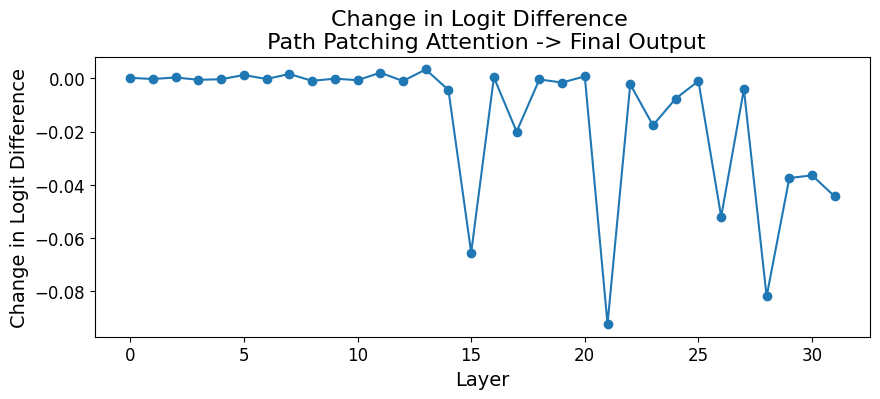

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
ax1.set_title("Change in Logit Difference \n Path Patching Attention -> Final Output", fontsize=16)
ax1.set_xlabel("Layer", fontsize=14)
ax1.set_ylabel("Change in Logit Difference", fontsize=14)
# Set xtick size
plt.xticks(fontsize=12)
plt.xticks(range(0, model.cfg.n_layers, 5))
# Set ytick size
plt.yticks(fontsize=12)

plt.plot(attn_extraction_results['attn_out'], marker='o')

plt.show()
fig.savefig(f"experiments/sports_facts_manual/results/{model_name.replace('/', '_')}_extraction_heads.pdf", bbox_inches='tight')


In [26]:
head_results = {}

for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        head_results[f"L{layer}H{head}"] = float(attn_extraction_results['z'][layer, head])

sorted_res = sorted(head_results.items(), key=lambda x: x[1], reverse=True)
# store as json file
with open(f"experiments/sports_facts_manual/results/{model_name.replace('/', '_')}_extraction_head_scores.json", 'w') as f:
    json.dump(sorted_res, f, indent=4)


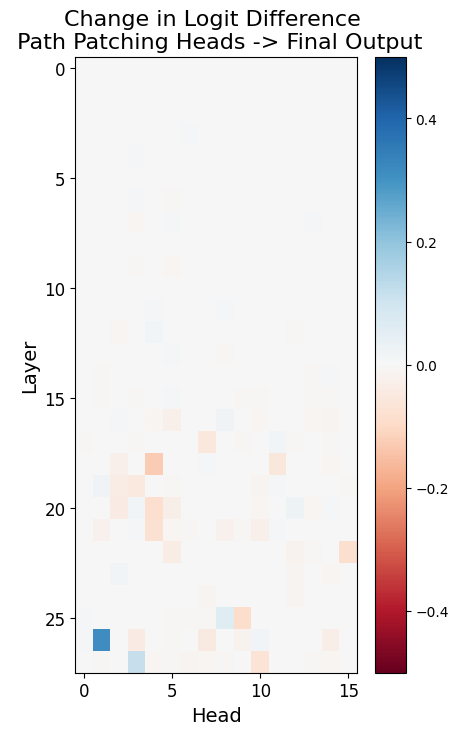

In [16]:
# Plot 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))

# Plot heat map with x being the head and y being the layer

ax1 = fig.add_subplot(121)
ax1.set_title("Change in Logit Difference \n Path Patching Heads -> Final Output", fontsize=16)
ax1.set_xlabel("Head", fontsize=14)
ax1.set_ylabel("Layer", fontsize=14)
# Set xtick size
plt.xticks(fontsize=12)
# Set ytick size
plt.yticks(fontsize=12)
# Add colormap
cbar = plt.colorbar(ax1.imshow(attn_extraction_results["z"].detach().cpu().numpy(), aspect='auto', cmap='RdBu', vmin=-0.5, vmax=0.5))
# Colormap label
# cbar.set_label('Logit Difference', rotation=90, labelpad=20, fontsize=14)
plt.show()
fig.savefig(f"experiments/sports_facts_manual/results/{model_name.replace('/', '_')}_extraction_heads.pdf", bbox_inches='tight')
